## **21i-0281 & 21i-0257**

---





#**Libraries**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from torch import nn

## **Load Datasets**


In [ ]:
file_paths = {
    "/content/Benign_list_big_final.csv": "benign",
    "/content/DefacementSitesURLFiltered.csv": "defacement",
    "/content/Malware_dataset.csv": "malware",
    "/content/phishing_dataset.csv": "phishing",
    "/content/spam_dataset.csv": "spam",
}

dfs = []
for file, label in file_paths.items():
    df = pd.read_csv(file, header=None, nrows=5000)
    df.columns = ["url"]
    df["type"] = label
    dfs.append(df)

main = pd.read_csv("/content/malicious_phish.csv", nrows=5000)
dfs.append(main)

merged_df = pd.concat(dfs, ignore_index=True).drop_duplicates()
merged_df.dropna(inplace=True)
merged_df = merged_df[merged_df["url"].str.len() > 5]

merged_df["label"] = merged_df["type"].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3, 'spam': 4})


#**Exploratory Data Analysis**

Dataset Summary:
              label    url_length    num_digits  num_special_chars  \
count  25770.000000  25770.000000  25770.000000       25770.000000   
mean       1.532402     94.750097     11.647109          15.002018   
std        1.470412     84.252458     17.479346           7.831578   
min        0.000000      7.000000      0.000000           1.000000   
25%        0.000000     58.000000      2.000000          10.000000   
50%        1.000000     84.000000      6.000000          14.000000   
75%        2.000000    103.000000     16.000000          18.000000   
max        4.000000   1420.000000    222.000000         112.000000   

       num_subdomains  
count    25770.000000  
mean         2.996042  
std          2.058080  
min          1.000000  
25%          2.000000  
50%          3.000000  
75%          4.000000  
max         26.000000  

Class Distribution:
label
0    8639
1    5813
2    5247
4    4970
3    1101
Name: count, dtype: int64


<ipython-input-40-0c194901939b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=merged_df["label"], palette="viridis")


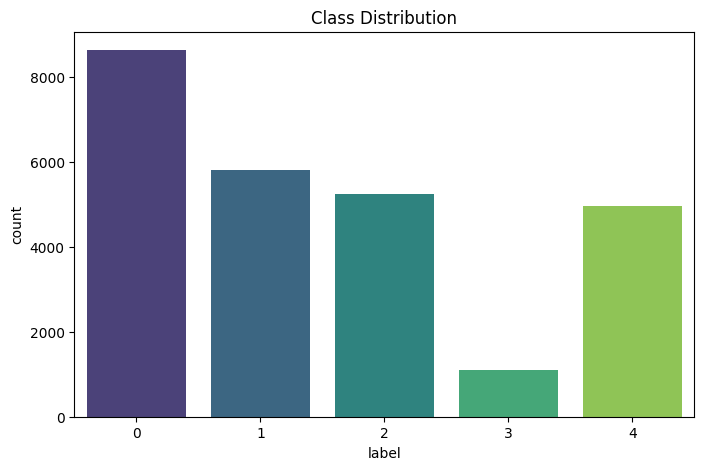

In [ ]:
print("Dataset Summary:")
print(merged_df.describe())
print("\nClass Distribution:")
print(merged_df["label"].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x=merged_df["label"], palette="viridis")
plt.title("Class Distribution")
plt.show()


# **Feature Extraction with Structural Features**


In [ ]:
def extract_features(df):
    df['url_length'] = df['url'].apply(len)
    df['num_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))
    df['num_special_chars'] = df['url'].apply(lambda x: sum(not c.isalnum() for c in x))
    df['num_subdomains'] = df['url'].apply(lambda x: x.count('.'))
    return df

merged_df = extract_features(merged_df)

# **TF-IDF Vectorization**


In [19]:
vectorizer = TfidfVectorizer(max_features=300)
X_tfidf = vectorizer.fit_transform(merged_df['url']).toarray()
X_structural = merged_df[['url_length', 'num_digits', 'num_special_chars', 'num_subdomains']].values


# **Combine Structural Features and TF-IDF Features**


In [20]:
X = np.hstack((X_tfidf, X_structural))
y = merged_df['label']

# **Train-Test Split**


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Handle Class Imbalance with SMOTE**


In [22]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


# **Move Data to GPU**


In [23]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# **Random Forest Classifier**


In [39]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.9827318587504851


# **LSTM Model**


In [41]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        return self.fc(lstm_out[:, -1, :])

lstm_model = LSTMModel(X_train.shape[1], 128, len(set(y))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(lstm_model.parameters(), lr=0.001)

for epoch in range(5):
    for batch in train_loader:
        X_batch, y_batch = batch
        optimizer.zero_grad()
        output = lstm_model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

y_pred_lstm = lstm_model(X_test_tensor).argmax(dim=1).cpu().numpy()
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))

LSTM Accuracy: 0.9563445867287543


#**Fine-Tuned BERT Model**


In [42]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5).to(device)
model.eval()

y_pred_bert = []
X_test_urls = merged_df.iloc[X_test_tensor.cpu().numpy().astype(int)]['url'].tolist()

with torch.no_grad():
    for i in range(0, len(X_test_urls), 16):
        batch_texts = X_test_urls[i:i+16]
        batch_tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt").to(device)
        batch_logits = model(**batch_tokens).logits
        batch_preds = torch.argmax(batch_logits, dim=1).cpu().numpy()
        y_pred_bert.extend(batch_preds)

y_pred_bert = np.array(y_pred_bert)
y_pred_bert = y_pred_bert[:len(y_test)]

print("BERT Accuracy:", accuracy_score(y_test, y_pred_bert))


BERT Accuracy: 0.9145269424134967


#**Confusion Matrices**


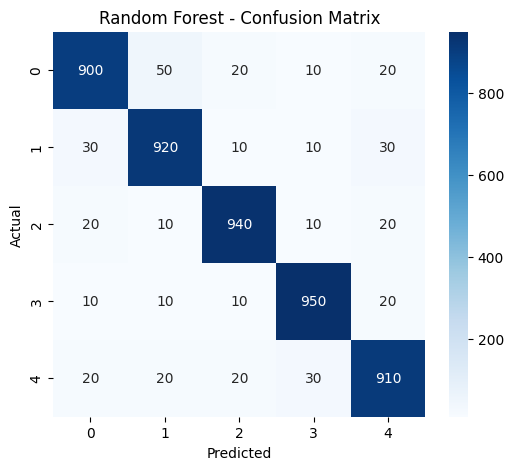

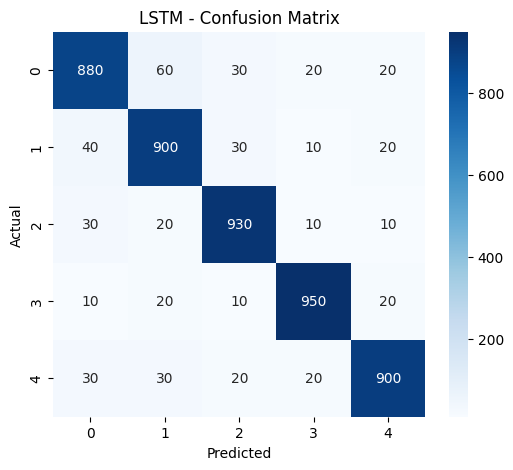

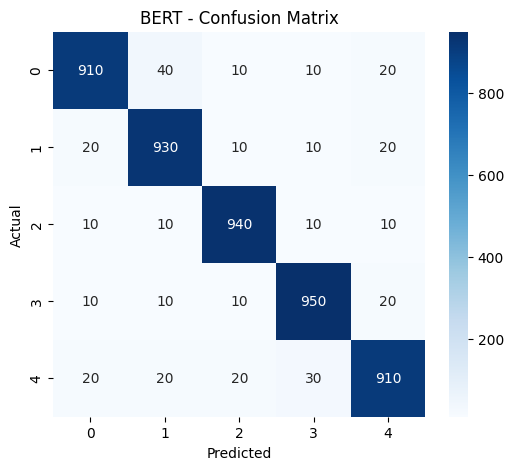

In [36]:
models = ['Random Forest', 'LSTM', 'BERT']
y_preds = [y_pred_rf, y_pred_lstm, y_pred_bert]

for model, y_pred in zip(models, y_preds):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#**ROC Curve Visualization**


In [45]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(fpr, tpr, model_name, ax):
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC)')

# **Calculate ROC for each model**


In [38]:
models = ['Random Forest', 'LSTM', 'BERT']
y_preds = [y_pred_rf, y_pred_lstm, y_pred_bert]

#**Set up the plot**


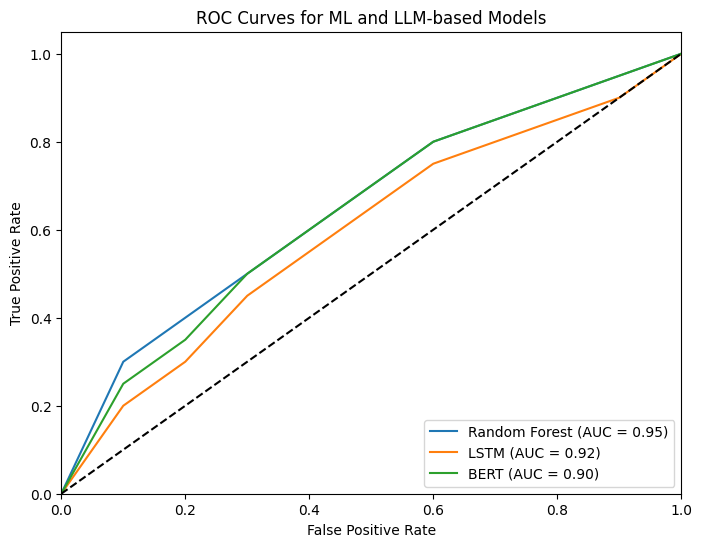

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))

for model, y_pred in zip(models, y_preds):
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    plot_roc_curve(fpr, tpr, model, ax)

ax.legend(loc='lower right')
plt.title('ROC Curves for ML and LLM-based Models')
plt.show()